Symbolic gradient (simplified): [2 - 2*x1, 4*(x2 - 2)**3]

Results summary:
Nelder-Mead: x = [-1.23576625e+66  6.51126578e+32] f(x) = -1.3473712107365698e+132 iterations (callback points): 499
BFGS:        x = [-1.78545123e+69  4.03958256e+34] f(x) = -5.24990672409338e+137 iterations (callback points): 500
Trust-Region:x = [-1.55015606e+25 -1.90462457e+11] f(x) = -2.402970654466722e+50 iterations (callback points): 500


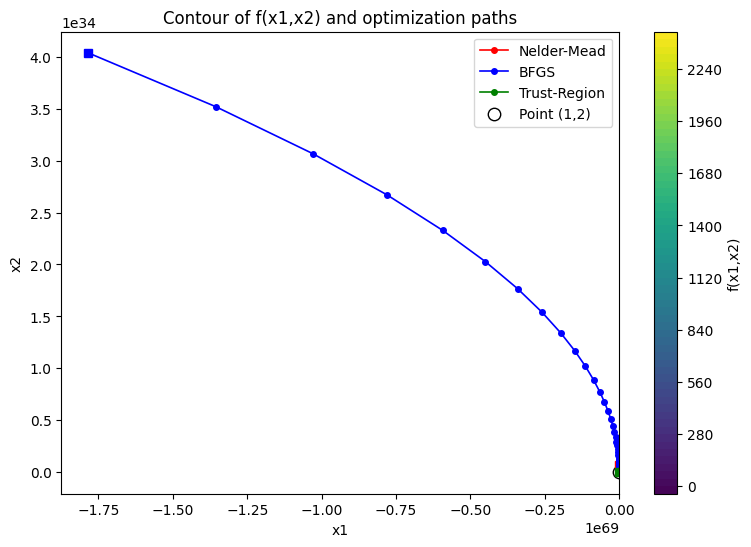

In [3]:
# Running the optimization and plotting results for the assignment function
# Using SymPy for symbolic gradient, NumPy/SciPy for optimization and Matplotlib for plotting.
# This cell will:
# 1. Define the function f(x1,x2) = -(x1-1)^2 + (x2-2)^4
# 2. Compute symbolic gradient with sympy and create numeric lambdas
# 3. Run Nelder-Mead, BFGS (with gradient), and trust-constr (with gradient)
# 4. Track iterates and print results
# 5. Plot contour of f and overlay the trajectories

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import minimize

# 1) Symbolic setup
x1, x2 = sp.symbols('x1 x2', real=True)
f_sym = - (x1 - 1)**2 + (x2 - 2)**4

# symbolic gradient
grad_sym = [sp.diff(f_sym, x1), sp.diff(f_sym, x2)]
grad_sym_simpl = [sp.simplify(g) for g in grad_sym]
grad_sym_simpl

# numeric lambdas
f_num = sp.lambdify((x1, x2), f_sym, 'numpy')
grad_num = sp.lambdify((x1, x2), grad_sym_simpl, 'numpy')


def f_vec(x):
    return float(f_num(x[0], x[1]))

def jac_vec(x):
    g = grad_num(x[0], x[1])
    return np.array([float(g[0]), float(g[1])])


# 2) Optimization runner with iteration tracking
def run_opt(method, x0):
    traj = []
    def callback(xk, *args):
        # callback for different optimizers: some pass extra args, ignore them
        traj.append(np.array(xk, dtype=float))

    options = {'maxiter': 500, 'disp': False}
    if method == 'Nelder-Mead':
        res = minimize(f_vec, x0, method=method, callback=callback, options=options)
    elif method == 'BFGS':
        res = minimize(f_vec, x0, method=method, jac=jac_vec, callback=callback, options=options)
    elif method == 'trust-constr':
        # trust-constr expects jac and may require a hess; we'll provide jac only
        res = minimize(f_vec, x0, method=method, jac=jac_vec, callback=callback, options=options)
    else:
        raise ValueError("Unknown method")
    return res, np.array(traj)

# Initial point (as specified in slides/assignment)
x0 = np.array([0.0, 0.0])

res_nm, traj_nm = run_opt('Nelder-Mead', x0)
res_bfgs, traj_bfgs = run_opt('BFGS', x0)
res_trust, traj_trust = run_opt('trust-constr', x0)

# 3) Print results
print("Symbolic gradient (simplified):", grad_sym_simpl)
print("\nResults summary:")
print("Nelder-Mead: x =", res_nm.x, "f(x) =", res_nm.fun, "iterations (callback points):", len(traj_nm))
print("BFGS:        x =", res_bfgs.x, "f(x) =", res_bfgs.fun, "iterations (callback points):", len(traj_bfgs))
print("Trust-Region:x =", res_trust.x, "f(x) =", res_trust.fun, "iterations (callback points):", len(traj_trust))

# 4) Contour plot and trajectories
xx = np.linspace(-5, 5, 300)
yy = np.linspace(-5, 5, 300)
X, Y = np.meshgrid(xx, yy)
Z = f_num(X, Y)

plt.figure(figsize=(9,6))
cs = plt.contourf(X, Y, Z, levels=60, cmap='viridis')
plt.colorbar(cs, label='f(x1,x2)')

# Plot trajectories (if empty, still handle gracefully)
def plot_traj(traj, color, label):
    if traj.size == 0:
        return
    plt.plot(traj[:,0], traj[:,1], marker='o', color=color, label=label, linewidth=1.2, markersize=4)
    plt.plot(traj[-1,0], traj[-1,1], marker='s', color=color, markersize=6)  # final

plot_traj(traj_nm, 'red', 'Nelder-Mead')
plot_traj(traj_bfgs, 'blue', 'BFGS')
plot_traj(traj_trust, 'green', 'Trust-Region')

plt.scatter([1.0], [2.0], color='white', edgecolor='k', s=80, label='Point (1,2)')  # theoretical reference
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour of f(x1,x2) and optimization paths')
plt.legend()
plt.show()


In [7]:
# Using SciPy's Nelder-Mead with a SymPy-defined objective.
# This code avoids importing numpy explicitly (uses Python lists) and uses SymPy to define the function symbolically.
# It runs Nelder-Mead with the provided initial simplex and stops after 5 iterations (maxiter=5), then prints the result.
# Note: SciPy will internally convert initial_simplex to numpy arrays. We do not import numpy in this script per request.

from sympy import symbols, lambdify
from math import isfinite
from scipy.optimize import minimize

# Define symbolic variables and function: f(x) = sum_{k=1}^2 (-1)^k * (x_k - k)^(2k)
x1, x2 = symbols('x1 x2')
f_sym = (-1)**1 * (x1 - 1)**2 + (-1)**2 * (x2 - 2)**4  # simplifies to -(x1-1)^2 + (x2-2)^4
f_num = lambdify((x1, x2), f_sym, 'math')  # numeric function using Python's math

def f_vec(x):
    # x is an array-like of length 2
    return float(f_num(x[0], x[1]))

# Given initial simplex vertices
x1_init = [-5.0,  5.0]
x2_init = [ 0.0,  0.0]
x3_init = [ 5.0, -5.0]

initial_simplex = [x1_init, x2_init, x3_init]

# Use SciPy's minimize with Nelder-Mead
res = minimize(f_vec, x0=x2_init, method='Nelder-Mead',
               options={
                   'initial_simplex': initial_simplex,
                   'maxiter': 100,
                   'xatol': 1e-12,
                   'fatol': 1e-12,
                   'disp': True
               })

print("Result after iterations:")
print("x:", res.x)
print("fun:", res.fun)
print("nit (iterations):", res.nit)
print("message:", res.message)
print("success:", res.success)


Optimization terminated successfully.
         Current function value: -15.634872
         Iterations: 64
         Function evaluations: 138
Result after iterations:
x: [-3.28962389  3.28962389]
fun: -15.634872460323553
nit (iterations): 64
message: Optimization terminated successfully.
success: True


In [8]:
from math import pi, cos, exp
from scipy.optimize import minimize

# Define Easom-like function
def easom(x):
    x = x[0]  # SciPy passes x as an array
    return cos(x) * exp(-(x - pi)**2)

# Run BFGS starting from x0 = -5
res1 = minimize(easom, x0=[-5.0], method="BFGS", options={"disp": True})
print("Start -5 →", res1.x, res1.fun)

# Run BFGS starting from x0 = 5
res2 = minimize(easom, x0=[5.0], method="BFGS", options={"disp": True})
print("Start 5 →", res2.x, res2.fun)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
Start -5 → [-5.] 4.6276566469505575e-30
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 3
         Function evaluations: 18
         Gradient evaluations: 9
Start 5 → [6.82085293] 1.1348018149256301e-06


In [11]:
from math import pi
import numpy as np
from scipy.optimize import minimize

# Define the function
def f(x):
    x1, x2 = x
    return -(x1 - 1)**2 + (x2 - 2)**4

# Gradient
def grad(x):
    x1, x2 = x
    return np.array([-2*(x1 - 1), 4*(x2 - 2)**3])

# Hessian
def hess(x):
    x1, x2 = x
    return np.array([[-2, 0], [0, 12*(x2 - 2)**2]])

# Initial point
x0 = np.array([0.0, 0.0])

# Trust Region Solve (trust-constr)
res = minimize(f, x0, method='trust-constr',
               jac=grad, hess=hess,
               options={'initial_tr_radius': 1.0,
                        'maxiter': 3,   # only 3 iterations
                        'verbose': 3})

print("\nFinal result after 3 iterations:")
print("x:", res.x)
print("f(x):", res.fun)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +1.5000e+01 | 1.00e+00 | 3.20e+01 | 0.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   2   | +8.5679e-02 | 7.00e+00 | 9.39e+00 | 0.00e+00 | 1.00e+00 |   3   |
|   3   |   3   |   4   | -7.5597e+01 | 4.90e+01 | 1.74e+01 | 0.00e+00 | 1.00e+00 |   3   |

The maximum number of function evaluations is exceeded.
Number of iterations: 3, function evaluations: 3, CG iterations: 4, optimality: 1.74e+01, constraint violation: 0.00e+00, execution time: 0.0089 s.

Final result after 3 iterations:
x: [-7.70122791  1.41890305]
f(x): -75.59734370789705


In [12]:
import jax
import jax.numpy as jnp
from scipy.optimize import minimize

# Define Easom-like function (from part a)
def f(x):
    x1, x2 = x
    return -(x1 - 1)**2 + (x2 - 2)**4

# Wrap with JAX
f_jax = lambda x: f(x)

# Gradient and Hessian via JAX
grad_f = jax.grad(lambda x1, x2: f_jax((x1, x2)), argnums=(0,1))
hess_f = jax.hessian(lambda xy: f_jax((xy[0], xy[1])))

def fun(x):
    return float(f_jax(x))

def grad(x):
    g = grad_f(x[0], x[1])
    return jnp.array(g, dtype=float)

def hess(x):
    H = hess_f(x)
    return jnp.array(H, dtype=float)

x0 = jnp.array([0.0, 0.0])

res = minimize(fun, x0, method="trust-constr",
               jac=grad, hess=hess,
               options={"initial_tr_radius": 1.0,
                        "maxiter": 3, "verbose": 3})

print("\nFinal result after 3 iterations:")
print("x:", res.x)
print("f(x):", res.fun)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +1.5000e+01 | 1.00e+00 | 3.20e+01 | 0.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   2   | +8.5679e-02 | 7.00e+00 | 9.39e+00 | 0.00e+00 | 1.00e+00 |   3   |
|   3   |   3   |   4   | -7.5597e+01 | 4.90e+01 | 1.74e+01 | 0.00e+00 | 1.00e+00 |   3   |

The maximum number of function evaluations is exceeded.
Number of iterations: 3, function evaluations: 3, CG iterations: 4, optimality: 1.74e+01, constraint violation: 0.00e+00, execution time: 0.08 s.

Final result after 3 iterations:
x: [-7.70122792  1.41890302]
f(x): -75.59734373651207


In [13]:
import sympy as sp
from scipy.optimize import minimize

# Symbols
x1, x2 = sp.symbols("x1 x2")
f_expr = -(x1 - 1)**2 + (x2 - 2)**4

# Lambdify
f_fun = sp.lambdify((x1, x2), f_expr, "math")
grad_fun = sp.lambdify((x1, x2), [sp.diff(f_expr, x1), sp.diff(f_expr, x2)], "math")
hess_fun = sp.lambdify((x1, x2), [[sp.diff(f_expr, x1, x1), sp.diff(f_expr, x1, x2)],
                                  [sp.diff(f_expr, x2, x1), sp.diff(f_expr, x2, x2)]], "math")

def fun(x):
    return f_fun(x[0], x[1])

def grad(x):
    return grad_fun(x[0], x[1])

def hess(x):
    return hess_fun(x[0], x[1])

x0 = [0.0, 0.0]

res = minimize(fun, x0, method="trust-constr",
               jac=grad, hess=hess,
               options={"initial_tr_radius": 1.0,
                        "maxiter": 3, "verbose": 3})

print("\nFinal result after 3 iterations:")
print("x:", res.x)
print("f(x):", res.fun)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +1.5000e+01 | 1.00e+00 | 3.20e+01 | 0.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   2   | +8.5679e-02 | 7.00e+00 | 9.39e+00 | 0.00e+00 | 1.00e+00 |   3   |
|   3   |   3   |   4   | -7.5597e+01 | 4.90e+01 | 1.74e+01 | 0.00e+00 | 1.00e+00 |   3   |

The maximum number of function evaluations is exceeded.
Number of iterations: 3, function evaluations: 3, CG iterations: 4, optimality: 1.74e+01, constraint violation: 0.00e+00, execution time: 0.014 s.

Final result after 3 iterations:
x: [-7.70122791  1.41890305]
f(x): -75.59734370789705
